# LSTM Composite Seq2Seq multi-day Price Sequence Prediction Demo
The goal of this demo is to show how a LSTM Composite Sequence-to-Sequence (LSTM Comp Seq2Seq) framework predicts a sequences of future prices. Specifically, our model is composed of an autoencoder and a predictor which the predictor utilizes the encoded deep representations from the autoencoder and learn to forecast multiple future timesteps of prices. Here, we forecast the 3 future timesteps of BTCUSD prices using an input of 48 timesteps. 

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import utils

from load_data import *
from LSTMComp import *

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/usr/local/lib/python2.7/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### Preparing and processing data:

For this example, we will only use OHLC data from BTCUSD, ETHXBT, XBTUSD

In [2]:
data, feature_cols, price_cols = load_OHLC_no_vol()
# data, feature_cols, price_cols = load_OHLCV()
# data, feature_cols, price_cols = load_ta()

In [3]:
#processing training and val dataset
val_size = 0.2
val_i = int(len(data) * (1 - val_size))

train = data.iloc[:val_i]
val = data.iloc[val_i:]

#normalize
train_mean = train.mean()
train_std = train.std()
train = (train - train_mean) / train_std

val_mean = val.mean()
val_std = val.std()
val = (val - val_mean) / val_std

After preparing and processing, we will train our model on the prices shown in blue and test our model on data shown in green:

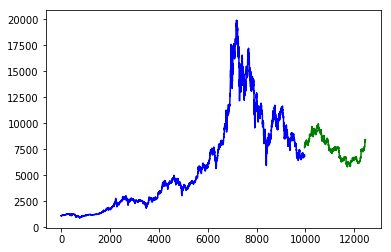

In [4]:
plt.figure()
plt.plot(data.iloc[:val_i].Close.as_matrix(), color='blue')
plt.plot(range(len(data.iloc[:val_i].Close.as_matrix()),len(data)), data.iloc[val_i:].Close.as_matrix(), color='green')
plt.show()

# Initializing LSTM Composite Seq2Seq

In [5]:
hidden_size = [128]

feature_size = len(feature_cols)
encoder_steps = 24
label_size = len(price_cols)
decoder_steps = 24

auto_lr = tf.placeholder(tf.float32)
pred_lr = tf.placeholder(tf.float32)

beta1 = 0.7
beta2 = 0.8
epsilon = 1e-6 #numerical stability
reverse = False

auto_optimizer = tf.train.AdamOptimizer(learning_rate=auto_lr, beta1=beta1, beta2=beta2, 
                                   epsilon=epsilon, name='auto_optimizer')
pred_optimizer = tf.train.AdamOptimizer(learning_rate=pred_lr, beta1=beta1, beta2=beta2, 
                                   epsilon=epsilon, name='pred_optimizer')
losses = []
ep = None
sess = tf.Session()
predictor = LSTMCompSeq2Seq(encoder_steps, feature_size, decoder_steps, label_size, 
                             hidden_size, sess, auto_optimizer, pred_optimizer, reverse=reverse)

INFO:tensorflow:Summary name encoder/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0-grad is illegal; using encoder/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/kernel_0-grad instead.
INFO:tensorflow:Summary name encoder/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0-grad is illegal; using encoder/rnn/multi_rnn_cell/cell_0/basic_lstm_cell/bias_0-grad instead.
INFO:tensorflow:Summary name autoencoder/decoder/d_weights:0-grad is illegal; using autoencoder/decoder/d_weights_0-grad instead.
INFO:tensorflow:Summary name autoencoder/decoder/d_biases:0-grad is illegal; using autoencoder/decoder/d_biases_0-grad instead.
INFO:tensorflow:Summary name autoencoder/decoder/multi_rnn_cell/cell_0/basic_lstm_cell/kernel:0-grad is illegal; using autoencoder/decoder/multi_rnn_cell/cell_0/basic_lstm_cell/kernel_0-grad instead.
INFO:tensorflow:Summary name autoencoder/decoder/multi_rnn_cell/cell_0/basic_lstm_cell/bias:0-grad is illegal; using autoencoder/decoder/multi_rnn_cell/cell_0/basic_lstm_cell/bia

## Training Autoencoder

In [6]:
#summary writer for Tensorboard
summaries_dir = './tmp/lstm-composite-log1'
merged = tf.summary.merge_all()
train_writer = tf.summary.FileWriter(summaries_dir + '/train',
                                      sess.graph)
sess.run(tf.global_variables_initializer())

We first train our autoencoder. As an example, we will train it for 10 epochs:

In [7]:
epochs = 10
print_step = 100
batch_size = 128
auto_lr = 1e-3
#training first encoding
for ep in range(epochs):
    if ep % print_step == 0:
        print 'Starting epoch: %d / %d' % (ep + 1, epochs)
        
    batch_X, _ = generate_train_sample(train[feature_cols].as_matrix(), train[price_cols].as_matrix(), 
                                             batch_size, encoder_steps, encoder_steps)
    
    loss, summary, auto_grad, _, op = predictor.train_autoencoder(batch_X, auto_lr, merged)
    
    losses.append(loss)
    train_writer.add_summary(summary, ep )
    train_writer.add_summary(auto_grad, ep)
    if ep % 100 == 0:
        print 'Epoch %d loss: %f' % (ep, loss)
#     if ep % 100 == 0:
#         plt.plot(np.array(losses))
#         plt.show()

Starting epoch: 1 / 10
Epoch 0 loss: 5.996050


## Training Composite

Now we will train our composite model simultaneously (autoencoder and Seq2Seq). Again, we will train for 10 epochs as an example:

In [8]:
epochs = 10
pred_losses = []
print_step = 100

batch_size = 128
auto_lr = 1e-4
pred_lr = 1e-5
ep = 0 if ep == None else ep
#training first encoding
for p_ep in range(epochs):
    if p_ep % print_step == 0:
        print 'Starting predictor epoch: %d / %d' % (p_ep + 1, epochs)
        
    batch_X, batch_y = generate_train_sample(train[feature_cols].as_matrix(), train[price_cols].as_matrix(), 
                                             batch_size, encoder_steps, decoder_steps)
    
    
    #train predictor
    pred_loss, pred_summary, pred_grad, _, op = predictor.train_predictor(batch_X, batch_y, pred_lr, merged)
    train_writer.add_summary(pred_summary, p_ep + ep)
    train_writer.add_summary(pred_grad, p_ep + ep)
    
        #train autoencoder
#     if p_ep % 10 == 0:
    loss, summary, auto_grad, _, op = predictor.train_autoencoder(batch_X, auto_lr, merged)
    train_writer.add_summary(summary, p_ep + ep)
    train_writer.add_summary(auto_grad, p_ep + ep)
    
    if p_ep % 100 == 0:
        print 'Epoch %d autoencoder loss: %f' % (p_ep + ep, loss)
        print 'Epoch %d predictor loss: %f' % (p_ep, pred_loss)
    
    #expo. increasing learning rates
#     pred_lr *= 1.0095
        
#     if ep % 100 == 0:
#         plt.plot(np.array(losses))
#         plt.show()

ep += p_ep

Starting predictor epoch: 1 / 10
Epoch 9 autoencoder loss: 0.746624
Epoch 0 predictor loss: 3.421340


Run the following command to view tensorboard in shell:

## Results

We can just use a pre-trained model to demonstrate the model's capabilities. Make sure it's in the right repo.

In [9]:
#load from checkpoint
saver = tf.train.Saver()
saver.restore(sess, './tmp/ckpts/btcusd-composite-128-24_24.ckpt')

INFO:tensorflow:Restoring parameters from ./tmp/ckpts/btcusd-composite-128-24_24.ckpt


We will first show our autoencoder's encoding quality on the test data:

In [10]:
start = 0
x, y = generate_test_sample(val[feature_cols].as_matrix().astype(np.float32), val[feature_cols].as_matrix().astype(np.float32), 
                            2000, start, encoder_steps, encoder_steps)
predictions = predictor.predict(x, predict_price=False)

In [11]:
col_index = 3
preds = remove_overlap(predictions[:,:,col_index].flatten(), encoder_steps)
x_ = remove_overlap(x[:,:,col_index].flatten(), encoder_steps)
feature_cols[col_index]

'Close'

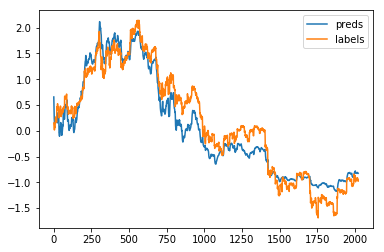

In [12]:
preds = pd.Series(preds,name='preds')
x_ = pd.Series(x_, name='labels')
pd.concat([preds.iloc[:], x_.iloc[:]],axis=1).plot()

Here's a close up on the autoencoding result of the BTCUSD closing price:

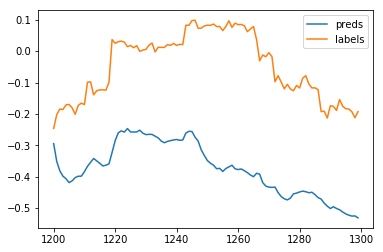

In [13]:
pd.concat([preds[1200:1300], x_[1200:1300]],axis=1).plot()

Here are the autoencoding result for ETHXBT closing price:

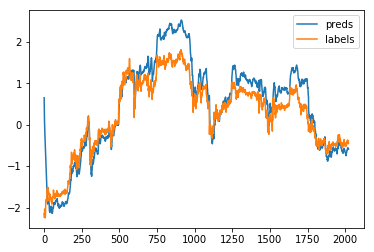

In [14]:
col_index = 7
preds = remove_overlap(predictions[:,:,col_index].flatten(), encoder_steps)
x_ = remove_overlap(x[:,:,col_index].flatten(), encoder_steps)
feature_cols[col_index]
preds = pd.Series(preds,name='preds')
x_ = pd.Series(x_, name='labels')
pd.concat([preds.iloc[:], x_.iloc[:]],axis=1).plot()

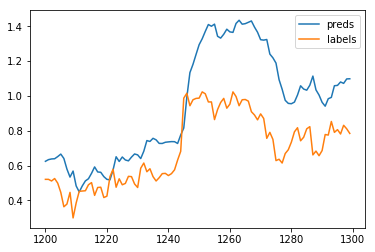

In [15]:
pd.concat([preds[1200:1300], x_[1200:1300]],axis=1).plot()

Finally, here are the prediction results for forecasting the next 24 timesteps based on a sequence of 24 timesteps:

In [16]:
start = 0
x, y = generate_test_sample(val[feature_cols].as_matrix().astype(np.float32), val[price_cols].as_matrix().astype(np.float32), 
                            2200, start, encoder_steps, decoder_steps)
y = remove_overlap(y.flatten(), decoder_steps)
predictions = predictor.predict(x)
predictions = remove_overlap(predictions.flatten(), decoder_steps)
predictions = pd.Series(predictions,name='preds')
y = pd.Series(y, name='labels')

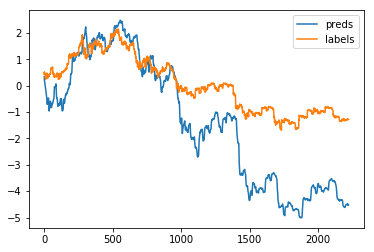

In [17]:
pd.concat([predictions[:], y[:]],axis=1).plot()

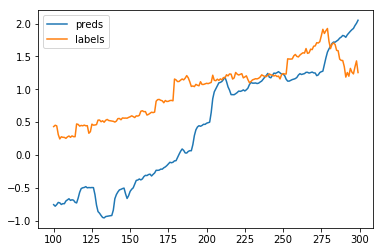

In [18]:
b = 100
c = 300
pd.concat([predictions[b:c], y[b:c]],axis=1).plot()